In [1]:
# load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
%matplotlib inline

# load required functionality from keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, AveragePooling2D
from keras.models import Model
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers import Add, Subtract
from keras.callbacks import ModelCheckpoint, EarlyStopping, History 
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as keras_backend


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
keras_backend.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15464051264244581302
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6700198133
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5936939552363696407
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

    track_id       image_path       lp  train
0  s01_l01_1  s01_l01/1_1.png  7C24698      1
1  s01_l01_2  s01_l01/2_1.png  7C24698      1
2  s01_l01_2  s01_l01/2_2.png  7C24698      1
3  s01_l01_2  s01_l01/2_3.png  7C24698      1
4  s01_l01_2  s01_l01/2_4.png  7C24698      1
182336
1200
2400
3600
4800
6000
7200
8400
9600
10800
12000
13200
14400
15600
16800
18000
19200
20400
21600
22800
24000
25200
26400
27600
28800
30000
31200
32400
33600
34800
36000
37200
38400
39600
40800
42000
43200
44400
45600
46800
48000
49200
50400
51600
52800
54000
55200
56400
57600
58800
60000
61200
62400
63600
64800
66000
67200
68400
69600
70800
72000
73200
74400
75600
76800
78000
79200
80400
81600
82800
84000
85200
86400
87600
88800
90000
91200
92400
93600
94800
96000
97200
98400
99600
100800
102000
103200
104400
105600
106800
108000
109200
110400
111600
112800
114000
115200
116400
117600
118800
120000
121200
122400
123600
124800
126000
127200
128400
129600
130800
132000
133200
134400
135600
136800
138000
139

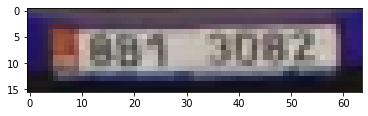

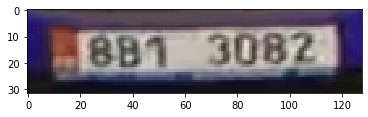

'\nfor i in range(800):\n    #str(i).zfill(4)\n    #format(i, \'04d\')\n    img = cv2.imread("../../DIV2K_train_HR/"+ format(i+1, \'04d\') + ".png")\n    print(img.shape)\n    #plt.imshow(img)\n    #plt.show()\n\nimg = cv2.imread("../../DIV2K_train_HR/0002.png")\nimg2 = img[0:1024, 0:1024,:]\nimg2 = img2[...,::-1] #bgr to rgb, inverse last 3 bgr to rgb\nplt.imshow(img2)\nplt.show()\n'

In [2]:
"""
    Reading Data from files
"""
import gc

data = pd.read_csv("../../image/trainVal.csv")
#print(data)
print(data.head())
#inputX = data[["Unnamed: 0", "w1 = 4"]].to_numpy() #需要為 np.array 的形式!

print(len(data))#182336

#train valid test
#total 105924
dataX = np.zeros((20000, 16, 64, 3), dtype=int)
dataY = np.zeros((20000, 32, 128, 3), dtype=int)
count = 0


# not load test yet, due to not enough memory
# total 76412
finalTestX = np.zeros((20000, 16, 64, 3), dtype=int)
finalTestY = np.zeros((20000, 32, 128, 3), dtype=int)
testCount = 0


#cv2.resize(src, dsize[, dst[, fx[, fy[, interpolation]]]]) → dst
i = 0
for j in range(len(data)):
    #img = cv2.imread("../../image/s01_l01/1_1.png")
    if data["train"][i] == 0:
        img = cv2.imread("../../image/" + data["image_path"][i])
        #print(img.shape)
        img = cv2.resize(img, (128, 32))
        finalTestY[testCount] = img
        img = cv2.resize(img, (64, 16))
        finalTestX[testCount] = img
        testCount += 1
    i+=3 
    if i % 1200 == 0:
        print(i)
        #gc.collect()
    if testCount == 20000:
        break;
    
print(testCount)
#print(testCount)
print(finalTestY.shape)
#print(dataY[8])
plt.imshow(finalTestX[5])
plt.show()
plt.imshow(finalTestY[5])
plt.show()
    
    

"""
for i in range(800):
    #str(i).zfill(4)
    #format(i, '04d')
    img = cv2.imread("../../DIV2K_train_HR/"+ format(i+1, '04d') + ".png")
    print(img.shape)
    #plt.imshow(img)
    #plt.show()

img = cv2.imread("../../DIV2K_train_HR/0002.png")
img2 = img[0:1024, 0:1024,:]
img2 = img2[...,::-1] #bgr to rgb, inverse last 3 bgr to rgb
plt.imshow(img2)
plt.show()
"""


In [3]:
"""
Peak Signal-to-Noise Ratio:
     > 40dB: great
    30~40dB: good
    20~30dB: bad
     < 20dB: worse
def psnr(tf_img1, tf_img2):
    return tf.image.psnr(tf_img1, tf_img2, max_val=255)
"""
def PSNR(y_true, y_pred):
    return -10. * np.log10(np.mean(np.square(y_pred - y_true)))

def printHistory(history): 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss 
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss']) 
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

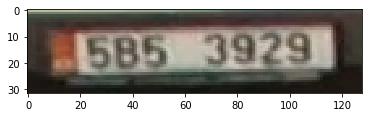

(20000, 16, 64, 3)


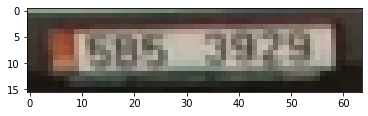

'\n# convert the class labels to 10-dimensional class arrays:\n# - before: y_train = (n_samples, )\n# - after: Y_train = (n_samples, 10)\n#\nY_train = np_utils.to_categorical(y_train, 10)\nY_test = np_utils.to_categorical(y_test, 10)\n'

In [4]:


"""
# reshape the data based on what backend is in use (TensorFlow or Thean)
if keras_backend.image_data_format() == 'channels_first': #Thean
    X_train = X_train.reshape(-1, 1, 28, 28)
    X_test = X_test.reshape(-1, 1, 28, 28)
else: # TensorFlow
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1) #(batch, height, width, channels)
"""

img = finalTestY[1, :, :, :]
plt.imshow(img)
plt.show()

print(finalTestX.shape)

img = finalTestX[1, :, :, :]
plt.imshow(img)
plt.show()

# convert data type and normalize the values (8-bit = 256 = 0...255)
finalTestX = finalTestX.astype('float32') / 255
finalTestY = finalTestY.astype('float32') / 255

"""
# convert the class labels to 10-dimensional class arrays:
# - before: y_train = (n_samples, )
# - after: Y_train = (n_samples, 10)
#
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
"""


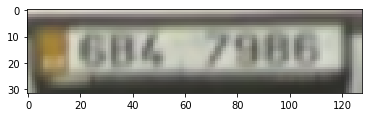

26.527907848358154


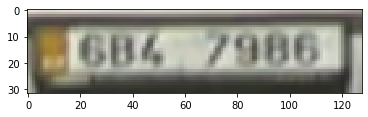

30.493738651275635


In [5]:
img = cv2.resize(X_train[1, :, :, :], (128, 32))
plt.imshow(img)
plt.show()
print(PSNR(img, y_train[1, :, :, :]))

img = cv2.resize(y_train[1, :, :, :], (64, 16))
img = cv2.resize(img, (128, 32), interpolation=cv2.INTER_CUBIC)
plt.imshow(img)
plt.show()
print(PSNR(img, y_train[1, :, :, :]))

In [14]:
# U-net

def UNet(pretrained_weights = None, input_size = (16,64,3)):
    inputs = Input(input_size)

    upConv0 = UpSampling2D(size=(2, 2), interpolation='bilinear')(inputs)
    
    # N*32*128*64
    conv1 = Conv2D(64, (3, 3), activation='relu', padding="same")(upConv0)
    #conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding="same")(conv1)
    
    # N*16*64*128
    maxPool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding="same")(maxPool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding="same")(conv2)
    
    # N*8*32*256
    maxPool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding="same")(maxPool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding="same")(conv3)
    
    # N*4*16*512
    maxPool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding="same")(maxPool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding="same")(conv4)
    
    # N*2*8*1024
    maxPool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding="same")(maxPool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding="same")(conv5)
    
    # N*4*16*512
    upConv1 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding="same")(concatenate([conv4,upConv1], axis=3))
    conv6 = Conv2D(512, (3, 3), activation='relu', padding="same")(conv6)
    
    # N*8*32*256
    upConv2 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding="same")(concatenate([conv3,upConv2], axis=3))
    conv7 = Conv2D(256, (3, 3), activation='relu', padding="same")(conv7)
    
    # N*16*64*128
    upConv3 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding="same")(concatenate([conv2,upConv3], axis=3))
    conv8 = Conv2D(128, (3, 3), activation='relu', padding="same")(conv8)

    # N*32*128*64
    upConv4 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding="same")(concatenate([conv1,upConv4], axis=3))
    conv9 = Conv2D(64, (3, 3), activation='relu', padding="same")(conv9)
    
    # N*32*128*3
    result = Conv2D(3, (1, 1), activation='sigmoid')(conv9)
    
    model = Model(input = inputs, output = result)
    
    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model
    
"""
#https://keras.io/zh/callbacks/
#keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
modelCheck = ModelCheckpoint('UNet32{epoch:08d}.h5', save_weights_only=True, save_best_only=True)
#keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
earlyStop = EarlyStopping(monitor='val_loss', patience=50)
history = History()

model.fit(X_train, y_train,
          batch_size=64,
          epochs=100,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[modelCheck, earlyStop, history])
"""

"\n#https://keras.io/zh/callbacks/\n#keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)\nmodelCheck = ModelCheckpoint('UNet32{epoch:08d}.h5', save_weights_only=True, save_best_only=True)\n#keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)\nearlyStop = EarlyStopping(monitor='val_loss', patience=50)\nhistory = History()\n\nmodel.fit(X_train, y_train,\n          batch_size=64,\n          epochs=100,\n          verbose=1,\n          validation_data=(X_test, y_test),\n          callbacks=[modelCheck, earlyStop, history])\n"

C:\Users\asus\Miniconda3\envs\testJ\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 16, 64, 3)    0                                            
__________________________________________________________________________________________________
up_sampling2d_6 (UpSampling2D)  (None, 32, 128, 3)   0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 128, 64)  1792        up_sampling2d_6[0][0]            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 128, 64)  36928       conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_poolin

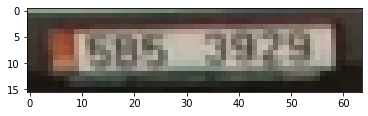

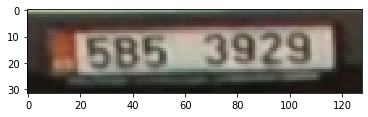

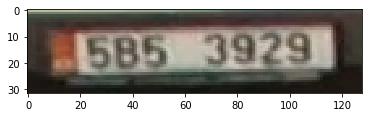

36.81945562362671
37.12187051773071


In [15]:
model = UNet("UNet3200000055.h5")
print("== UNet accuracy ==")
score = model.evaluate(finalTestX, finalTestY, verbose=0)
print('Valid loss:', score[0])
print('Valid accuracy:', score[1])

result = model.predict(finalTestX)
img = finalTestX[1]
plt.imshow(img)
plt.show()
# show the image
img = result[1]
plt.imshow(img)
plt.show()
img = finalTestY[1]
plt.imshow(img)
plt.show()

print( PSNR(result[1], finalTestY[1]) )
print( PSNR(result, finalTestY) )

C:\Users\asus\Miniconda3\envs\testJ\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 16, 64, 3)    0                                            
__________________________________________________________________________________________________
up_sampling2d_6 (UpSampling2D)  (None, 32, 128, 3)   0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 128, 64)  1792        up_sampling2d_6[0][0]            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 128, 64)  36928       conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_poolin

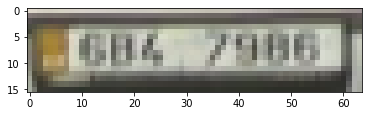

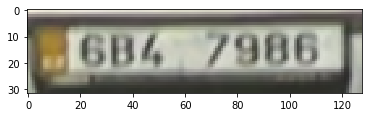

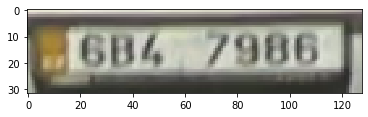

38.71704339981079
38.931920528411865


In [8]:
model2 = UNet("UNet3200000055.h5")
print("== UNet accuracy ==")
score = model2.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
score = model2.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

result = model2.predict(X_train)
img = X_train[1]
plt.imshow(img)
plt.show()
# show the image
img = result[1]
plt.imshow(img)
plt.show()
img = y_train[1]
plt.imshow(img)
plt.show()
print(PSNR(y_train[1], result[1]) )
print(PSNR(y_train, result) )

C:\Users\asus\Miniconda3\envs\testJ\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("up...)`
  if __name__ == '__main__':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 16, 64, 3)         0         
_________________________________________________________________
up_sampling2d_16 (UpSampling (None, 32, 128, 3)        0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
None


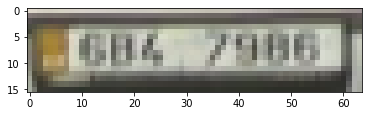

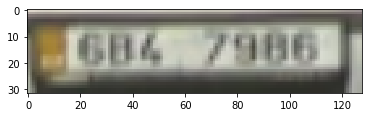

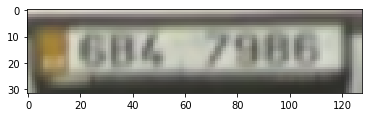

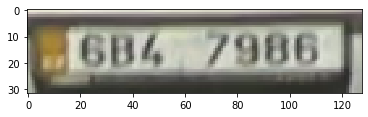

23.588621616363525
26.527907848358154
26.70764446258545


In [14]:
# CV2 的 resize 效果比 upsampling2D 好

def testUpConv(pretrained_weights = None, input_size = (16,64,3)):
    inputs = Input(input_size)

    #upConv0 = UpSampling2D(size=(2, 2), interpolation='bilinear')(inputs)
    upConv0 = UpSampling2D(size=(2, 2), interpolation='bilinear')(inputs)
    
    model = Model(input = inputs, output = upConv0)
    
    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model
    
model3 = testUpConv()
result2 = model3.predict(X_train)


img = X_train[1]
plt.imshow(img)
plt.show()
# show the image
img = result2[1]
plt.imshow(img)
plt.show()

img2 = cv2.resize(X_train[1], (128, 32))
plt.imshow(img2)
plt.show()

img = y_train[1]
plt.imshow(img)
plt.show()
print(PSNR(y_train[1], result2[1]) )
print(PSNR(y_train[1], img2) )
print(PSNR(result2[1], img2) )

In [5]:
# U-net
from keras.layers import Conv2DTranspose

def UNetTransposeConv(pretrained_weights = None, input_size = (16,64,3)):
    inputs = Input(input_size)

    #upConv0 = UpSampling2D(size=(2, 2), interpolation='bilinear')(inputs)
    upConv0 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(inputs)
    
    # N*32*128*64
    conv1 = Conv2D(64, (3, 3), activation='relu', padding="same")(upConv0)
    #conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding="same")(conv1)
    
    # N*16*64*128
    maxPool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding="same")(maxPool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding="same")(conv2)
    
    # N*8*32*256
    maxPool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding="same")(maxPool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding="same")(conv3)
    
    # N*4*16*512
    maxPool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding="same")(maxPool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding="same")(conv4)
    
    # N*2*8*1024
    maxPool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding="same")(maxPool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding="same")(conv5)
    
    # N*4*16*512
    #upConv1 = UpSampling2D(size=(2, 2))(conv5)
    upConv1 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(conv5)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding="same")(concatenate([conv4,upConv1], axis=3))
    conv6 = Conv2D(512, (3, 3), activation='relu', padding="same")(conv6)
    
    # N*8*32*256
    #upConv2 = UpSampling2D(size=(2, 2))(conv6)
    upConv2 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(conv6)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding="same")(concatenate([conv3,upConv2], axis=3))
    conv7 = Conv2D(256, (3, 3), activation='relu', padding="same")(conv7)
    
    # N*16*64*128
    #upConv3 = UpSampling2D(size=(2, 2))(conv7)
    upConv3 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(conv7)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding="same")(concatenate([conv2,upConv3], axis=3))
    conv8 = Conv2D(128, (3, 3), activation='relu', padding="same")(conv8)

    # N*32*128*64
    #upConv4 = UpSampling2D(size=(2, 2))(conv8)
    upConv4 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(conv8)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding="same")(concatenate([conv1,upConv4], axis=3))
    conv9 = Conv2D(64, (3, 3), activation='relu', padding="same")(conv9)
    
    # N*32*128*3
    result = Conv2D(3, (1, 1), activation='sigmoid')(conv9)
    
    model = Model(input = inputs, output = result)
    
    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model
    


Instructions for updating:
Colocations handled automatically by placer.


C:\Users\asus\Miniconda3\envs\testJ\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_transpose_1 (Conv2DTrans (None, 32, 128, 64)  1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 128, 64)  36928       conv2d_transpose_1[0][0]         
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 128, 64)  36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

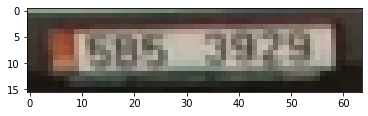

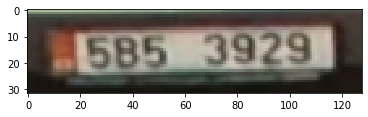

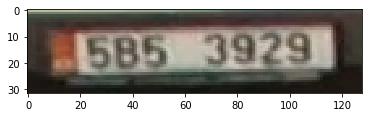

36.746249198913574
37.02805995941162


In [6]:
model = UNetTransposeConv("UNetTransposeConv200038.h5")
print("== UNetTransposeConv accuracy ==")
score = model.evaluate(finalTestX, finalTestY, verbose=0)
print('Valid loss:', score[0])
print('Valid accuracy:', score[1])

result = model.predict(finalTestX)
img = finalTestX[1]
plt.imshow(img)
plt.show()
# show the image
img = result[1]
plt.imshow(img)
plt.show()
img = finalTestY[1]
plt.imshow(img)
plt.show()

print( PSNR(result[1], finalTestY[1]) )
print( PSNR(result, finalTestY) )

In [23]:
def UNetRes(pretrained_weights = None, input_size = (16,64,3)):
    inputs = Input(input_size)

    #upConv0 = UpSampling2D(size=(2, 2), interpolation='bilinear')(inputs)
    upConv0 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(inputs)
    
    # N*32*128*64
    conv1 = Conv2D(64, (3, 3), activation='relu', padding="same")(upConv0)
    #conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding="same")(conv1)
    
    # N*16*64*128
    maxPool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding="same")(maxPool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding="same")(conv2)
    
    # N*8*32*256
    maxPool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding="same")(maxPool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding="same")(conv3)
    
    # N*4*16*512
    maxPool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding="same")(maxPool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding="same")(conv4)
    
    # N*2*8*1024
    maxPool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding="same")(maxPool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding="same")(conv5)
    
    # N*4*16*512
    #upConv1 = UpSampling2D(size=(2, 2))(conv5)
    upConv1 = Conv2DTranspose(512, (3,3), strides=2, padding='same')(conv5)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding="same")(Add()([conv4,upConv1]))
    conv6 = Conv2D(512, (3, 3), activation='relu', padding="same")(conv6)
    
    # N*8*32*256
    #upConv2 = UpSampling2D(size=(2, 2))(conv6)
    upConv2 = Conv2DTranspose(256, (3,3), strides=2, padding='same')(conv6)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding="same")(Add()([conv3,upConv2]))
    conv7 = Conv2D(256, (3, 3), activation='relu', padding="same")(conv7)
    
    # N*16*64*128
    #upConv3 = UpSampling2D(size=(2, 2))(conv7)
    upConv3 = Conv2DTranspose(128, (3,3), strides=2, padding='same')(conv7)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding="same")(Add()([conv2,upConv3]))
    conv8 = Conv2D(128, (3, 3), activation='relu', padding="same")(conv8)

    # N*32*128*64
    #upConv4 = UpSampling2D(size=(2, 2))(conv8)
    upConv4 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(conv8)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding="same")(Add()([conv1,upConv4]))
    conv9 = Conv2D(64, (3, 3), activation='relu', padding="same")(conv9)
    
    # N*32*128*3
    result = Conv2D(3, (1, 1), activation='sigmoid')(conv9)
    
    model = Model(input = inputs, output = result)
    
    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model
    

C:\Users\asus\Miniconda3\envs\testJ\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_transpose_31 (Conv2DTran (None, 32, 128, 64)  1792        input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_153 (Conv2D)             (None, 32, 128, 64)  36928       conv2d_transpose_31[0][0]        
__________________________________________________________________________________________________
conv2d_154 (Conv2D)             (None, 32, 128, 64)  36928       conv2d_153[0][0]                 
__________________________________________________________________________________________________
max_poolin

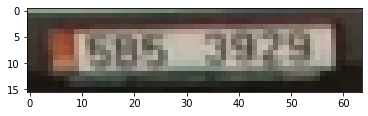

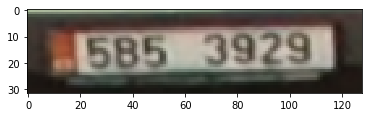

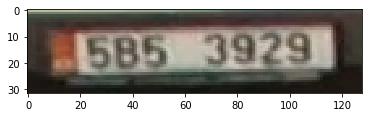

36.50662660598755
36.95319414138794


In [26]:
model = UNetRes("UNetRes00000051.h5")
print("== UNetRes accuracy ==")
score = model.evaluate(finalTestX, finalTestY, verbose=0)
print('Valid loss:', score[0])
print('Valid accuracy:', score[1])

result = model.predict(finalTestX)
img = finalTestX[1]
plt.imshow(img)
plt.show()
# show the image
img = result[1]
plt.imshow(img)
plt.show()
img = finalTestY[1]
plt.imshow(img)
plt.show()

print( PSNR(result[1], finalTestY[1]) )
print( PSNR(result, finalTestY) )

In [27]:
# version4
def Inception_block(inputX, filters=64, kernel_size=(3,3), increase=False):
    a = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(inputX)
    a = Conv2D(96, (1, 1), activation="relu", padding="same")(a)
    
    b = Conv2D(96, (1, 1), activation="relu", padding="same")(inputX)
    
    c = Conv2D(64, (1, 1), activation="relu", padding="same")(inputX)
    c = Conv2D(96, (3, 3), activation="relu", padding="same")(c)
    
    d = Conv2D(64, (1, 1), activation="relu", padding="same")(inputX)
    d = Conv2D(96, (3, 3), activation="relu", padding="same")(d)
    d = Conv2D(96, (3, 3), activation="relu", padding="same")(d)
    
    result = concatenate([a, b, c, d], axis=3)
    
    return result

def Inception_resnet_block(inputX, filterSize):
    #google v4res 
    finalSize = filterSize
    filterSize = 64
    
    a = Conv2D(filterSize, (1, 1), activation="relu", padding="same")(inputX)
    
    b = Conv2D(filterSize, (1, 1), activation="relu", padding="same")(inputX)
    b = Conv2D(filterSize, (3, 3), activation="relu", padding="same")(b)
    
    c = Conv2D(filterSize, (1, 1), activation="relu", padding="same")(inputX)
    c = Conv2D(filterSize*3//2, (3, 3), activation="relu", padding="same")(c)
    c = Conv2D(filterSize*3//2, (3, 3), activation="relu", padding="same")(c)

    filterSize = finalSize
    
    merge = concatenate([a, b, c], axis=3)
    merge = Conv2D(filterSize, (1, 1), activation="relu", padding="same")(merge)
    
    #shortcut
    result = Add()([merge, inputX])
    result = Activation("relu")(result)
    
    return result

def Inception(pretrained_weights = None, input_size = (16,64,3)):
    inputs = Input(input_size)

    #upConv0 = UpSampling2D(size=(2, 2), interpolation='bilinear')(inputs)
    upConv0 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(inputs)
    
    # N*32*128*64
    conv1 = Conv2D(64, (1, 1), activation='relu', padding="same")(upConv0)
    #conv1 = BatchNormalization()(conv1)
    conv1 = Inception_resnet_block(conv1, 64)
    #conv1 = Inception_resnet_block(conv1, 64)
    
    # N*16*64*128
    maxPool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (1, 1), activation='relu', padding="same")(maxPool1)
    conv2 = Inception_resnet_block(conv2, 128)
    #conv2 = Inception_resnet_block(conv2, 128)
    
    # N*8*32*256
    maxPool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, (1, 1), activation='relu', padding="same")(maxPool2)
    conv3 = Inception_resnet_block(conv3, 256)
    #conv3 = Inception_resnet_block(conv3, 256)
    
    # N*4*16*512
    maxPool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, (1, 1), activation='relu', padding="same")(maxPool3)
    conv4 = Inception_resnet_block(conv4, 512)
    #conv4 = Inception_resnet_block(conv4, 512)
    
    # N*2*8*1024
    maxPool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, (1, 1), activation='relu', padding="same")(maxPool4)
    conv5 = Inception_resnet_block(conv5, 1024)
    #conv5 = Inception_resnet_block(conv5, 1024)
    
    # N*4*16*512
    #upConv1 = UpSampling2D(size=(2, 2))(conv5)
    upConv1 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(conv5)
    conv6 = Conv2D(512, (1, 1), activation='relu', padding="same")(concatenate([conv4,upConv1], axis=3))
    conv6 = Inception_resnet_block(conv6, 512)
    #conv6 = Inception_resnet_block(conv6, 512)
    
    # N*8*32*256
    #upConv2 = UpSampling2D(size=(2, 2))(conv6)
    upConv2 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(conv6)
    conv7 = Conv2D(256, (1, 1), activation='relu', padding="same")(concatenate([conv3,upConv2], axis=3))
    conv7 = Inception_resnet_block(conv7, 256)
    #conv7 = Inception_resnet_block(conv7, 256)
    
    # N*16*64*128
    #upConv3 = UpSampling2D(size=(2, 2))(conv7)
    upConv3 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(conv7)
    conv8 = Conv2D(128, (1, 1), activation='relu', padding="same")(concatenate([conv2,upConv3], axis=3))
    conv8 = Inception_block(conv8, 128)
    #conv8 = Inception_block(conv8, 128)

    # N*32*128*64
    #upConv4 = UpSampling2D(size=(2, 2))(conv8)
    upConv4 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(conv8)
    conv9 = Conv2D(64, (1, 1), activation='relu', padding="same")(concatenate([conv1,upConv4], axis=3))
    conv9 = Inception_resnet_block(conv9, 64)
    #conv9 = Inception_resnet_block(conv9, 64)
    
    # N*32*128*3
    result = Conv2D(3, (1, 1), activation='sigmoid')(conv9)
    
    model = Model(input = inputs, output = result)
    
    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model
    

C:\Users\asus\Miniconda3\envs\testJ\lib\site-packages\ipykernel_launcher.py:111: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_transpose_41 (Conv2DTran (None, 32, 128, 64)  1792        input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_245 (Conv2D)             (None, 32, 128, 64)  4160        conv2d_transpose_41[0][0]        
__________________________________________________________________________________________________
conv2d_249 (Conv2D)             (None, 32, 128, 64)  4160        conv2d_245[0][0]                 
__________________________________________________________________________________________________
conv2d_247

== Inception accuracy ==
Valid loss: 0.000182336319074966
Valid accuracy: 0.9234834228515625


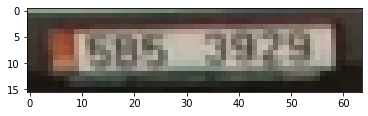

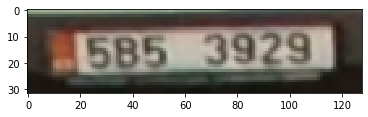

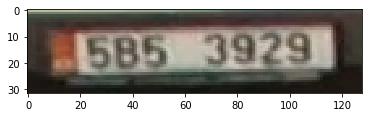

35.074570178985596
37.39126682281494


In [29]:
model = Inception("Inception044.h5")
print("== Inception accuracy ==")
score = model.evaluate(finalTestX, finalTestY, verbose=0)
print('Valid loss:', score[0])
print('Valid accuracy:', score[1])

result = model.predict(finalTestX)
img = finalTestX[1]
plt.imshow(img)
plt.show()
# show the image
img = result[1]
plt.imshow(img)
plt.show()
img = finalTestY[1]
plt.imshow(img)
plt.show()

print( PSNR(result[1], finalTestY[1]) )
print( PSNR(result, finalTestY) )

In [30]:
# Residual Network
from keras.layers import Lambda
import tensorflow as tf

def SubpixelConv2D(scale, **kwargs):
    return Lambda(lambda x: tf.depth_to_space(x, scale), **kwargs)

def residual_block(inputX, kernel_size, increase=False):
    if keras_backend.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
        
    #first
    x = Conv2D(192, kernel_size, padding="same")(inputX)
    x = Activation("relu")(x)

    #second 
    x = Conv2D(64, kernel_size, padding="same")(x)
    
    if increase:
        inputX = Conv2D(64 * 4, kernel_size=(1,1), strides=stride, padding='same')(inputX)
        inputX = BatchNormalization(axis=bn_axis)(inputX)

    #shortcut
    x = Add()([x, inputX])
    return x


def wdsra(pretrained_weights = None, scale=2, num_res_blocks=8, input_size=(16,64,3)):
    inputs = Input(input_size)
    
    #start
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    #x = BatchNormalization(axis=bn_axis)(x)
    #x = Activation('relu')(x)
    #x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    #residual
    for i in range(num_res_blocks):
        x = residual_block(x, 3)
        #x = origin_residual_block(x)
    x = Conv2D(3 * scale**2, (3,3), padding='same')(x)
    x = SubpixelConv2D(scale)(x) # N*32*128*3

    #shortcut
    s = Conv2D(3 * scale**2, (5,5), padding='same')(inputs)
    s = SubpixelConv2D(scale)(s) # N*32*128*3
    
    result = Add()([x, s])
    
    model = Model(input = inputs, output = result)
    
    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model
"""
keras_backend.clear_session() #release GPU memory
from numba import cuda
cuda.select_device(0)
cuda.close()
"""



'\nkeras_backend.clear_session() #release GPU memory\nfrom numba import cuda\ncuda.select_device(0)\ncuda.close()\n'

C:\Users\asus\Miniconda3\envs\testJ\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ad...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 16, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_337 (Conv2D)             (None, 16, 64, 64)   1792        input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_338 (Conv2D)             (None, 16, 64, 192)  110784      conv2d_337[0][0]                 
__________________________________________________________________________________________________
activation_25 (Activation)      (None, 16, 64, 192)  0           conv2d_338[0][0]                 
__________________________________________________________________________________________________
conv2d_339

== wdsra accuracy ==
Valid loss: 0.00018720434092683717
Valid accuracy: 0.9012529541015625


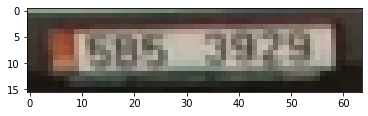

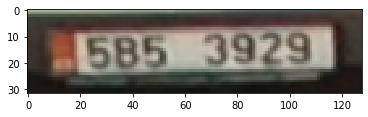

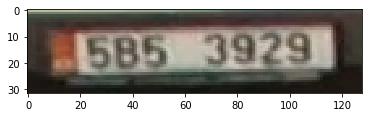

35.72335243225098
37.2768235206604


In [32]:
model = wdsra("wdsra00000099.h5")
print("== wdsra accuracy ==") #Residual
score = model.evaluate(finalTestX, finalTestY, verbose=0)
print('Valid loss:', score[0])
print('Valid accuracy:', score[1])

result = model.predict(finalTestX)
img = finalTestX[1]
plt.imshow(img)
plt.show()
# show the image
img = result[1]
plt.imshow(img)
plt.show()
img = finalTestY[1]
plt.imshow(img)
plt.show()

print( PSNR(result[1], finalTestY[1]) )
print( PSNR(result, finalTestY) )

In [35]:
from keras.layers import Lambda
import tensorflow as tf

def SubpixelConv2D(scale, **kwargs):
    return Lambda(lambda x: tf.depth_to_space(x, scale), **kwargs)

def residual_block(inputX, kernel_size, increase=False):
    if keras_backend.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
        
    #first
    x = Conv2D(192, kernel_size, padding="same")(inputX)
    x = Activation("relu")(x)

    #second 
    x = Conv2D(64, kernel_size, padding="same")(x)
    
    if increase:
        inputX = Conv2D(64 * 4, kernel_size=(1,1), strides=stride, padding='same')(inputX)
        inputX = BatchNormalization(axis=bn_axis)(inputX)

    #shortcut
    x = Add()([x, inputX])
    return x

def Inception_resnet_block(inputX, filterSize):
    #google v4res 
    finalSize = filterSize
    filterSize = 64
    
    a = Conv2D(filterSize, (1, 1), activation="relu", padding="same")(inputX)
    
    b = Conv2D(filterSize, (1, 1), activation="relu", padding="same")(inputX)
    b = Conv2D(filterSize, (3, 3), activation="relu", padding="same")(b)
    
    c = Conv2D(filterSize, (1, 1), activation="relu", padding="same")(inputX)
    c = Conv2D(filterSize*3//2, (3, 3), activation="relu", padding="same")(c)
    c = Conv2D(filterSize*3//2, (3, 3), activation="relu", padding="same")(c)

    filterSize = finalSize
    
    merge = concatenate([a, b, c], axis=3)
    merge = Conv2D(filterSize, (1, 1), activation="relu", padding="same")(merge)
    
    #shortcut
    result = Add()([merge, inputX])
    result = Activation("relu")(result)
    
    return result

def Ensemble(pretrained_weights = None, input_size = (16,64,3), scale=2, num_res_blocks=8):
    inputs = Input(input_size)

    #upConv0 = UpSampling2D(size=(2, 2), interpolation='bilinear')(inputs)
    upConv0 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(inputs)
    
    # N*32*128*64
    conv1 = Conv2D(64, (1, 1), activation='relu', padding="same")(upConv0)
    #conv1 = BatchNormalization()(conv1)
    conv1 = Inception_resnet_block(conv1, 64)
    #conv1 = Inception_resnet_block(conv1, 64)
    
    # N*16*64*128
    maxPool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (1, 1), activation='relu', padding="same")(maxPool1)
    conv2 = Inception_resnet_block(conv2, 128)
    #conv2 = Inception_resnet_block(conv2, 128)
    
    # N*8*32*256
    maxPool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, (1, 1), activation='relu', padding="same")(maxPool2)
    conv3 = Inception_resnet_block(conv3, 256)
    #conv3 = Inception_resnet_block(conv3, 256)
    
    # N*4*16*512
    maxPool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, (1, 1), activation='relu', padding="same")(maxPool3)
    conv4 = Inception_resnet_block(conv4, 512)
    #conv4 = Inception_resnet_block(conv4, 512)
    
    # N*2*8*1024
    maxPool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, (1, 1), activation='relu', padding="same")(maxPool4)
    conv5 = Inception_resnet_block(conv5, 1024)
    #conv5 = Inception_resnet_block(conv5, 1024)
    
    # N*4*16*512
    #upConv1 = UpSampling2D(size=(2, 2))(conv5)
    upConv1 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(conv5)
    conv6 = Conv2D(512, (1, 1), activation='relu', padding="same")(concatenate([conv4,upConv1], axis=3))
    conv6 = Inception_resnet_block(conv6, 512)
    #conv6 = Inception_resnet_block(conv6, 512)
    
    # N*8*32*256
    #upConv2 = UpSampling2D(size=(2, 2))(conv6)
    upConv2 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(conv6)
    conv7 = Conv2D(256, (1, 1), activation='relu', padding="same")(concatenate([conv3,upConv2], axis=3))
    conv7 = Inception_resnet_block(conv7, 256)
    #conv7 = Inception_resnet_block(conv7, 256)
    
    # N*16*64*128
    #upConv3 = UpSampling2D(size=(2, 2))(conv7)
    upConv3 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(conv7)
    conv8 = Conv2D(128, (1, 1), activation='relu', padding="same")(concatenate([conv2,upConv3], axis=3))
    conv8 = Inception_block(conv8, 128)
    #conv8 = Inception_block(conv8, 128)

    # N*32*128*64
    #upConv4 = UpSampling2D(size=(2, 2))(conv8)
    upConv4 = Conv2DTranspose(64, (3,3), strides=2, padding='same')(conv8)
    conv9 = Conv2D(64, (1, 1), activation='relu', padding="same")(concatenate([conv1,upConv4], axis=3))
    conv9 = Inception_resnet_block(conv9, 64)
    #conv9 = Inception_resnet_block(conv9, 64)
    
    # N*32*128*3
    result = Conv2D(3, (1, 1), activation='sigmoid')(conv9)
    
    
    
    #==== ResNet Part ====
    x = Conv2D(64, (3, 3), padding='same')(inputs)

    #residual
    for i in range(num_res_blocks):
        x = residual_block(x, 3)
        #x = origin_residual_block(x)
    x = Conv2D(3 * scale**2, (3,3), padding='same')(x)
    x = SubpixelConv2D(scale)(x) # N*32*128*3

    #shortcut
    s = Conv2D(3 * scale**2, (5,5), padding='same')(inputs)
    s = SubpixelConv2D(scale)(s) # N*32*128*3
    
    result = Add()([x, s, result])
    
    
    model = Model(input = inputs, output = result)
    
    
   
    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)
    
    return model



C:\Users\asus\Miniconda3\envs\testJ\lib\site-packages\ipykernel_launcher.py:139: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ad...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 16, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_transpose_46 (Conv2DTran (None, 32, 128, 64)  1792        input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_375 (Conv2D)             (None, 32, 128, 64)  4160        conv2d_transpose_46[0][0]        
__________________________________________________________________________________________________
conv2d_379 (Conv2D)             (None, 32, 128, 64)  4160        conv2d_375[0][0]                 
__________________________________________________________________________________________________
conv2d_377

== Ensemble accuracy ==
Valid loss: 0.00019341920662554912
Valid accuracy: 0.8826047729492188


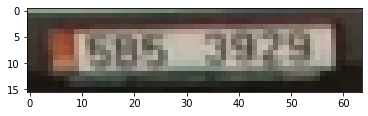

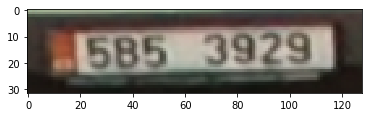

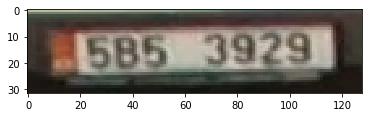

35.587642192840576
37.13502645492554


In [36]:
model = Ensemble("Ensemble00000043.h5")
print("== Ensemble accuracy ==")
score = model.evaluate(finalTestX, finalTestY, verbose=0)
print('Valid loss:', score[0])
print('Valid accuracy:', score[1])

result = model.predict(finalTestX)
img = finalTestX[1]
plt.imshow(img)
plt.show()
# show the image
img = result[1]
plt.imshow(img)
plt.show()
img = finalTestY[1]
plt.imshow(img)
plt.show()

print( PSNR(result[1], finalTestY[1]) )
print( PSNR(result, finalTestY) )